In [1]:
import torch as tr
import numpy as np
from CSW import *

from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
seed = 0
tr.manual_seed(seed)
np.random.seed(seed)

In [3]:
# task
pr = 1.0
taskL = [CSWTask(pr),CSWTask(1-pr)]

eval_pathL = [
  [10,0,1,4,5],       
  [11,0,1,3,5],
  ]

xeval = taskL[0].format_Xeval(eval_pathL)
xeval = tr.tensor(xeval)

# convenience 
softmax = lambda ulog: tr.softmax(ulog,-1)


In [4]:
def train_and_eval(stsize,learn_rate,block_len):
  """
  train network, and eval on paths from both graphs at
    every epoch of training.
  returns array with softmax prediction of network on each
    timestep of each path. 
  """
  neps = 200
  # init net, loss, optimizer
  net = CSWNet(stsize,seed)
  lossop = tr.nn.CrossEntropyLoss()
  optiop = tr.optim.Adam(net.parameters(), lr=learn_rate)
  # record y_softmax for on paths for graph A and B for each epoch of training
  tdim,sm_dim=5,12
  ysm = -np.ones([2,neps,tdim,sm_dim])
  ## train loop
  task_int = 0
  for ep in range(neps):
    # test phase: always interleaved
    if ep == 160: 
      block_len = 1
    # flip graph during training
    elif ep%block_len==0:
      task_int = (task_int+1)%2
      task = taskL[task_int]
      filler_id = 10+task_int 
    # forward prop  
    path = task.sample_path()
    xtrain,ytrain = task.dataset_onestory_with_marker(path=path,filler_id=filler_id,depth=1)
    yh = net(xtrain) # (time,smunits)
    # eval
    for idx,xev in enumerate(xeval):
      ysm_t = softmax(net(xev)).detach().numpy()
      ysm[idx,ep] = ysm_t
    # backprop
    for tstep in range(len(xtrain)):
      loss = lossop(yh[tstep].unsqueeze(0),ytrain[tstep])
      optiop.zero_grad()
      loss.backward(retain_graph=True)
      optiop.step()
  return ysm



### interleaved: good learning / blocked: catastrophic interference

In [8]:
stsize = 40
learn_rate = 0.01
block_len = 1
ysm_interleaved = train_and_eval(stsize,learn_rate,block_len=1)
ysm_blocked = train_and_eval(stsize,learn_rate,block_len=40)
print(ysm_interleaved.shape) 
# (graph,epoch,time_step,output_unit)

(2, 200, 5, 12)


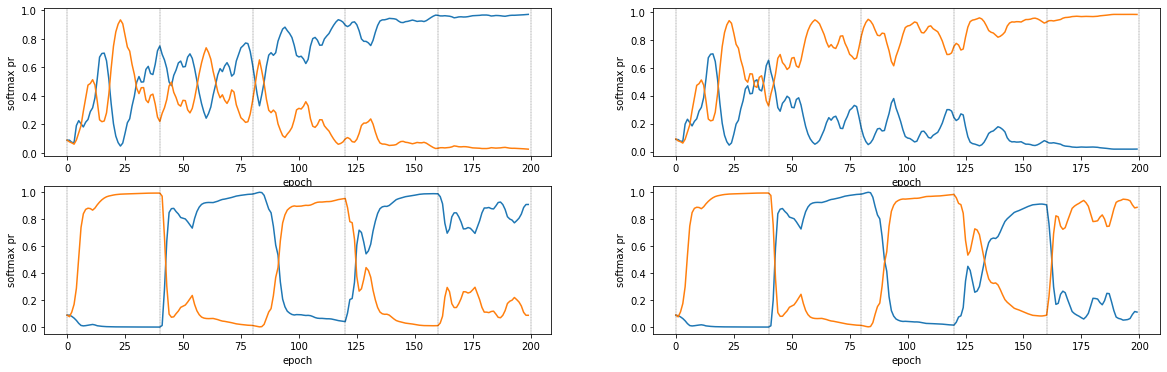

In [12]:
fig,axarr = plt.subplots(2,2,figsize=(20,6))
for bi_idx in range(2):
  ysm = [ysm_interleaved,ysm_blocked][bi_idx]
  for graph_idx in range(2):
    ax = axarr[bi_idx,graph_idx]
    ax.plot(ysm[graph_idx,:,2,(3,4)].T)
    ax.set_ylabel('softmax pr')
    ax.set_xlabel('epoch')

    for block_t in range(0,201,40):
      ax.axvline(block_t,c='k',ls='--',lw=.3)